# **TASK 6 :  BERT fine-tuning for classification**

To understand practical use of Transformer-based architectures, you will fine-tune pre-trained BERT for the downstream task of classification.
Again, we will mainly follow the corresponding TF Tutorial on BERT fine-tuning.
Sections ‘Saving the model’ and ‘Appendix’ are not necessary for the assignment.

We will make a few adaptations to the tutorial.

The tutorial data set GLUE MRPC is classifying sentence pairs.
In the assignment, please use a data set to classify single sentences.
For example, GLUE itself has such data sets, like COLA or SST2, which are provided as TFDS.
You need to adapt the data preprocessing to be used for this task.
The suggested building of the model with bert.bert_models.classifier_model() is a very high-level abstraction.
Instead of using this function, take a pre-trained BERT encoder and connect it to a classification model yourself.
This way, you can understand better how the information flow from input through encoder to classifier.
With those adaptations, follow the tutorial and fine-tune a pre-trained BERT on classification.
In addition to the evaluation based on training/evaluation set, run queries you made yourself to test generalization of the classifier.
Comment: I think there is a bug in result = tf.argmax(result).numpy() - the argmax should be over axis=1. (try processing more than 2 sequences)

Here are a few questions for you to check how well you understood the tutorial.
Please answer them (briefly) in your solution!

What is the tutorial classifying when using the GLUE MRPC data set?
In addition to the input itself, the tutorial feeds two binary tensors for input mask and input type to the model.
Is this necessary for the data set single sentence classification?
How does the tokenization in BERT differ from the one in the previous Task 5?
What is a [CLS] token and what is it used for?
Which part of the BERT encoding is used for the classification?
Does your answer match the output shape of the encoder?
Are the BERT encoder weights also fine-tuned to the task?

In [60]:
from google.colab import drive
drive.mount('/content/drive')
path_to_folder = '/content/drive/My Drive/Colab Notebooks/IDL_FinalSubmission/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
!pip install -q tf-models-official==2.3.0

In [62]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [4]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [63]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [64]:
!pwd

/content


In [65]:
glue, info = tfds.load('glue/cola', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

In [66]:
list(glue.keys())

['test', 'train', 'validation']

In [67]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})

In [68]:
info.features['label'].names

['unacceptable', 'acceptable']

In [109]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 1
sentence : b'It is this hat that it is certain that he was wearing.'


In [110]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [111]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [112]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [113]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence"]])

In [114]:
print("Sentence shape:", sentence.shape.as_list())

Sentence shape: [8551, None]


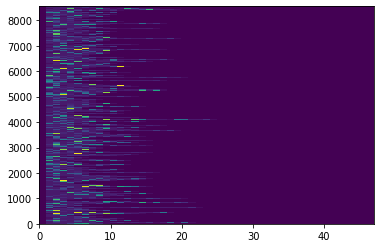

In [115]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence.shape[0]
input_word_ids = tf.concat([cls, sentence], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

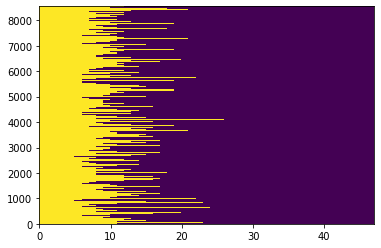

In [116]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

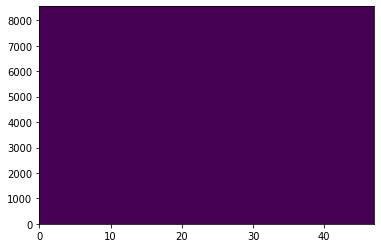

In [117]:
type_cls = tf.zeros_like(cls)
type_s = tf.zeros_like(sentence)

input_type_ids = tf.concat([type_cls, type_s], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [118]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence"])
  
  sentence = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence"])])


  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence.shape[0]
  input_word_ids = tf.concat([cls, sentence], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s = tf.zeros_like(sentence)
  input_type_ids = tf.concat(
      [type_cls, type_s], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [119]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

In [120]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (8551, 47)
input_mask      shape: (8551, 47)
input_type_ids  shape: (8551, 47)
glue_train_labels shape: (8551,)


In [121]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [126]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

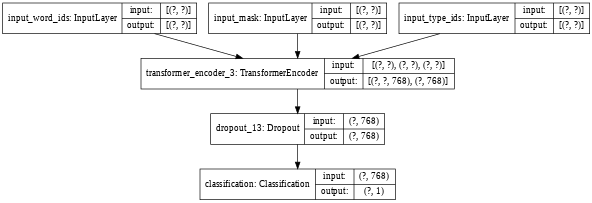

In [125]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [127]:
transformer_config = config_dict.copy()

# You need to rename a few fields to make this work:
transformer_config['attention_dropout_rate'] = transformer_config.pop('attention_probs_dropout_prob')
transformer_config['activation'] = tf_utils.get_activation(transformer_config.pop('hidden_act'))
transformer_config['dropout_rate'] = transformer_config.pop('hidden_dropout_prob')
transformer_config['initializer'] = tf.keras.initializers.TruncatedNormal(
          stddev=transformer_config.pop('initializer_range'))
transformer_config['max_sequence_length'] = transformer_config.pop('max_position_embeddings')
transformer_config['num_layers'] = transformer_config.pop('num_hidden_layers')

transformer_config

{'activation': <function official.modeling.activations.gelu.gelu>,
 'attention_dropout_rate': 0.1,
 'dropout_rate': 0.1,
 'hidden_size': 768,
 'initializer': <tensorflow.python.keras.initializers.initializers_v2.TruncatedNormal at 0x7f940494efd0>,
 'intermediate_size': 3072,
 'max_sequence_length': 512,
 'num_attention_heads': 12,
 'num_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [128]:
manual_classifier = nlp.modeling.models.BertClassifier(
        bert_encoder,
        num_classes=2,
        dropout_rate=transformer_config['dropout_rate'],
        initializer=tf.keras.initializers.TruncatedNormal(
          stddev=bert_config.initializer_range))

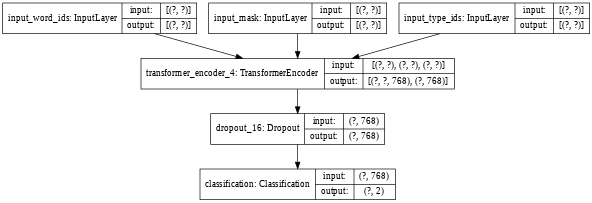

In [129]:
tf.keras.utils.plot_model(manual_classifier, show_shapes=True, dpi=48)

In [130]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}

manual_classifier(
    glue_batch, training=True
).numpy()

array([[ 2.8208649e-01,  7.5253099e-04],
       [ 1.4678837e-01,  2.3845997e-01],
       [ 1.4985096e-01,  1.7138395e-01],
       [ 1.7079422e-01,  4.9447261e-02],
       [ 2.9689199e-01,  6.2712476e-02],
       [ 7.7917933e-02,  1.3862178e-04],
       [-8.3621293e-02,  5.2776910e-02],
       [ 3.5704315e-02,  2.5457981e-01],
       [ 3.2929581e-01,  2.2788972e-01],
       [ 2.4535187e-01,  2.0508501e-01]], dtype=float32)

In [131]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[ 2.4020672e-04,  1.7949048e-01],
       [-3.6568382e-01,  8.2808949e-02],
       [-3.3506906e-01, -9.6571267e-02],
       [-2.2238657e-01, -6.8295002e-04],
       [-5.3623021e-02,  7.2811142e-02],
       [-1.5273592e-01, -3.1098656e-02],
       [-2.8793490e-01,  1.5427563e-01],
       [-2.5482011e-01,  1.0894859e-01],
       [-2.4621522e-01,  7.5756028e-02],
       [-1.7974719e-01,  2.3080219e-01]], dtype=float32)

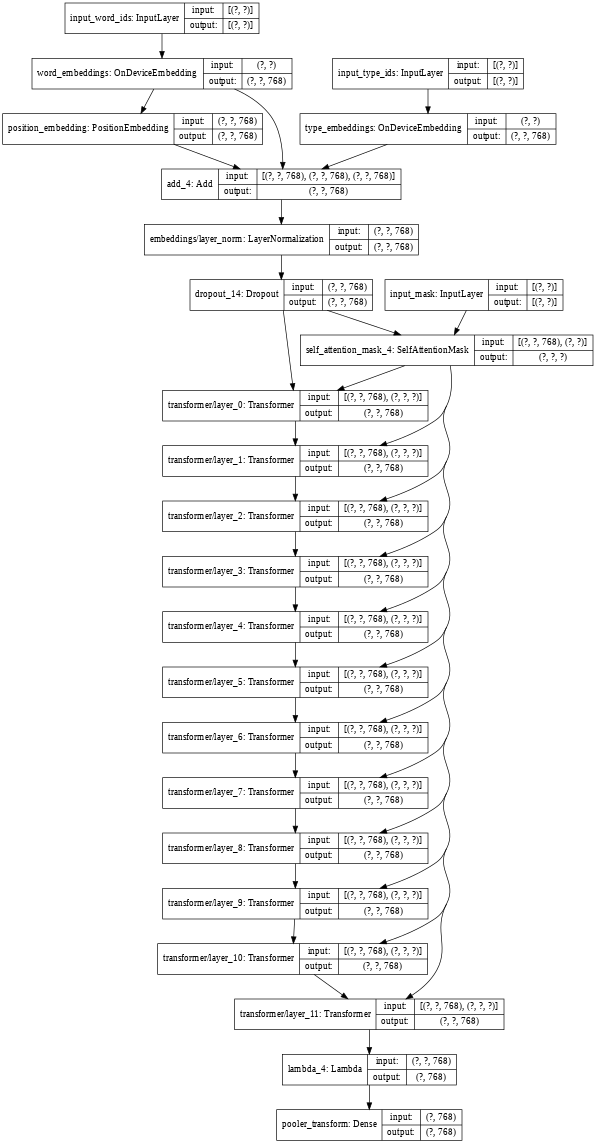

In [132]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [133]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [134]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [135]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

## Bert Classifier

In [136]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=10,
      epochs=epochs)

Epoch 1/3
856/856 [==============================] - 73s 86ms/step - loss: 0.4745 - accuracy: 0.7710 - val_loss: 0.4336 - val_accuracy: 0.8073
Epoch 2/3
856/856 [==============================] - 72s 85ms/step - loss: 0.3224 - accuracy: 0.8702 - val_loss: 0.4336 - val_accuracy: 0.8073
Epoch 3/3
856/856 [==============================] - 72s 84ms/step - loss: 0.3209 - accuracy: 0.8729 - val_loss: 0.4336 - val_accuracy: 0.8073


In [137]:
print(glue_train)

{'input_word_ids': <tf.Tensor: shape=(8551, 47), dtype=int32, numpy=
array([[ 101, 2009, 2003, ...,    0,    0,    0],
       [ 101, 2014, 8114, ...,    0,    0,    0],
       [ 101, 2119, 1996, ...,    0,    0,    0],
       ...,
       [ 101, 2198, 2246, ...,    0,    0,    0],
       [ 101, 2017, 2056, ...,    0,    0,    0],
       [ 101, 2054, 2057, ...,    0,    0,    0]], dtype=int32)>, 'input_mask': <tf.Tensor: shape=(8551, 47), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_type_ids': <tf.Tensor: shape=(8551, 47), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>}


In [138]:
my_examples = bert_encode(
    glue_dict = {
        'sentence':[
            'It mostly rains on the flat lands of Spain.']
    },
    tokenizer=tokenizer)

In [146]:
my_examples = bert_encode(
    glue_dict = {
        'sentence':['The rain in Spain falls mainly on the plain.',
            'Is it working? This does not match.']
    },
    tokenizer=tokenizer)

In [139]:
result = bert_classifier(my_examples, training=False)
result = tf.argmax(result).numpy()
result

array([0, 0])

In [140]:
np.array(info.features['label'].names)[result]

array(['unacceptable', 'unacceptable'], dtype='<U12')

## Manual Classifier

In [141]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

manual_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

manual_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3
268/268 [==============================] - 51s 191ms/step - loss: 0.9496 - accuracy: 0.1976 - val_loss: 0.9863 - val_accuracy: 0.1735
Epoch 2/3
268/268 [==============================] - 50s 187ms/step - loss: 0.9458 - accuracy: 0.2023 - val_loss: 0.9863 - val_accuracy: 0.1735
Epoch 3/3
268/268 [==============================] - 50s 187ms/step - loss: 0.9476 - accuracy: 0.2044 - val_loss: 0.9863 - val_accuracy: 0.1735


In [142]:
print(glue_train)

{'input_word_ids': <tf.Tensor: shape=(8551, 47), dtype=int32, numpy=
array([[ 101, 2009, 2003, ...,    0,    0,    0],
       [ 101, 2014, 8114, ...,    0,    0,    0],
       [ 101, 2119, 1996, ...,    0,    0,    0],
       ...,
       [ 101, 2198, 2246, ...,    0,    0,    0],
       [ 101, 2017, 2056, ...,    0,    0,    0],
       [ 101, 2054, 2057, ...,    0,    0,    0]], dtype=int32)>, 'input_mask': <tf.Tensor: shape=(8551, 47), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_type_ids': <tf.Tensor: shape=(8551, 47), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>}


In [160]:
my_examples = bert_encode(
    glue_dict = {
        'sentence':[
            'The rain in Spain falls mainly on the plain.']
    },
    tokenizer=tokenizer)

In [161]:
result = manual_classifier(my_examples, training=False)
result = tf.argmax(result, axis = 1).numpy()
result

array([0])

In [162]:
np.array(info.features['label'].names)[result]

array(['unacceptable'], dtype='<U12')

In [ ]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [ ]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'],
                            my_examples['input_mask'],
                            my_examples['input_type_ids']], training=False)

original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())

[[-1.0910212   0.79825974]
 [-2.024804    1.5023154 ]]

[[-1.0910217  0.7982602]
 [-2.024804   1.5023154]]


Observation

What is the tutorial classifying when using the GLUE MRPC data set?
<br>
Answer : The tutorial classifying when using the GLUE MRPC data set is for two sentences symantically correctness. They should be symantically equivalent. 
<br>
<br>
In addition to the input itself, the tutorial feeds two binary tensors for input mask and input type to the model.
Is this necessary for the data set single sentence classification?
<br>
Answer : The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the input_word_ids, and contains a 1 anywhere the input_word_ids is not padding. The "input type" also has the same shape, but inside the non-padded region, contains a 0 or a 1 indicating which sentence the token is a part of. As the input is of variable lenght, both the input mask and input type. 
<br>
<br>
How does the tokenization in BERT differ from the one in the previous Task 5?
<br>
Answer : Here in BERT it is searching for the word in vocab.txt, if the word is found a index is assigned to it, if it is not found, BERT starts splitting the word till there are meaningful words made out of it or till all letters are used up. For example - there is no word as "powerpoint" in its dictinorary ,so it splits to power and point. It works on the basis of Wordpiece algorithm. 
This is different from the one used in the Task 5, where each word was assigned an id and was seperated by spaces. 
<br>
<br>
What is a [CLS] token and what is it used for?
<br>
Answer : This input is expected to start with a [CLS] "This is a classification problem" token, and each sentence should end with a [SEP] "Separator" token.
<br>
<br>
Which part of the BERT encoding is used for the classification?
<br>
Answer: BERT has two outputs, we are taking the second one for classification.
<br>
<br>
Does your answer match the output shape of the encoder?
<br>
Answer: Output shape is (batchSize, 768)
<br>
<br>
Are the BERT encoder weights also fine-tuned to the task?
<br>
We are only fine tuning the classifier and not the encoder of the BERT. So BERT encoder weights are not fine tuned to the task. 
<br>